In [1]:
import os
from glob import glob
import copy
import itertools


import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as mdates

from smrt import make_model, make_snowpack, make_ice_column, make_interface, make_emmodel, sensor_list

from smrt.core.fresnel import brewster_angle, fresnel_coefficients

from smrt.core.layer import layer_properties
from smrt.core.globalconstants import FREEZING_POINT


from smrt.emmodel.symsce_torquato21 import derived_SymSCETK21
from smrt.permittivity.snow_mixing_formula import wetsnow_permittivity_memls, wetsnow_permittivity_hallikainen86

from esa_4d_antarctica.modeling import GoodSnowpacks, depth, frequency_colors, \
                                    total_liquid_water, prepare_wet_snowpacks, \
                                    prepare_saturated_snowpacks, smos_amsr2, lband_adjusted_snowpack
from esa_4d_antarctica.location import site_name

runner=None

In [2]:
sites = ['aws11', 'aws5', 'amery', 'shackleton', 'aws19', 'aws15', 'aws17',
       'wilkins']

(-20.0, 0.0)

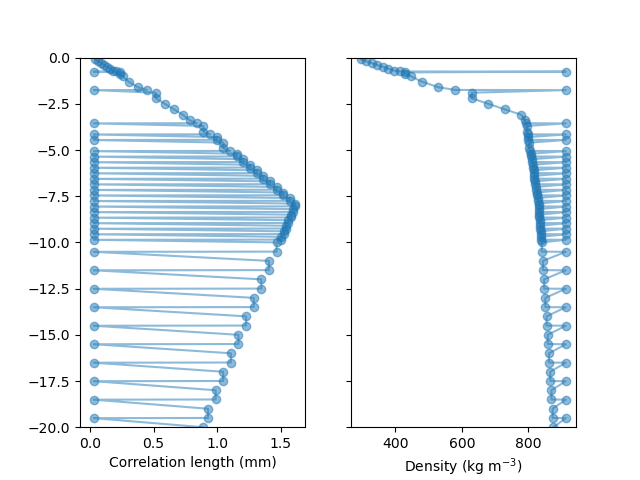

In [3]:

location = "aws19"
site0 = GoodSnowpacks(location, "winter", version=31)

season = 'winter'

f, axs = plt.subplots(1, 2, sharey=True)
z = -np.array(depth)

best_params = site0.best_params
# best 
sp = site0.prepare_best_snowpack()
#axs[0].plot([l.microstructure.compute_ssa() for l in sp.layers], -sp.layer_depths, '-o', alpha=0.5)
axs[0].plot([l.microstructure.corr_length * 1000 for l in sp.layers], -sp.layer_depths, '-o', alpha=0.5)

axs[1].plot(sp.layer_densities[:-1], -sp.layer_depths[:-1], '-o', alpha=0.5)

#axs[0].set_xlabel("SSA (m$^2$kg$^{-1}$)")
axs[0].set_xlabel("Correlation length (mm)")
axs[1].set_xlabel("Density (kg m$^{-3}$)")

axs[0].set_ylim((-20, 0))

In [4]:
# function to run smrt simulation for an ensemble of snowpacks and to return a convenient dataframe

def run_simulations(snowpacks, **kwargs):
        
    res = m.run(radiometer, snowpacks, parallel_computation=True, runner=runner, **kwargs).to_dataframe()
    return res


    res_l = m.run(smos, lband_adjusted_snowpack(snowpacks), parallel_computation=True, runner=runner, **kwargs).to_dataframe()
    res = res.join(res_l, rsuffix="_dup")
     
    return res.drop(columns=[c for c in res.columns if c.endswith("_dup")])

# Experiment 1: Sensitivity to TWC in a given snowpack. Wet snow layer 10cm thick. 

In [5]:
               
                
freqs = ['06', '10', '19', '37']
channels = [freq + pol for freq in freqs for pol in 'HV']
radiometer = sensor_list.amsr2(channels)
smos = sensor_list.smos()
#radar = [sensor_list.quikscat(), sensor_list.ascat(theta=40)]


drysp = site0.prepare_best_snowpack(season_temperature=273)

dort = "dort"

wet_mixing = 'MEMLS'
#wet_mixing = 'base'
#wet_mixing = 'H86'

if wet_mixing == 'base':
    m = make_model("symsce_torquato21",
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan'))
    m64 = make_model("symsce_torquato21",
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan', n_max_stream=64))
elif wet_mixing == 'MEMLS':
    m = make_model(derived_SymSCETK21(wetsnow_permittivity_memls),
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan'))
    m64 = make_model(derived_SymSCETK21(wetsnow_permittivity_memls),
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan', n_max_stream=64))
    
elif wet_mixing == 'H86':
    # the formulation of H86 has no absorption for liquid water =0 (it was not designed for that)
    # Because of this, we have to add the ice absorption.
    @layer_properties("density", "liquid_water")
    def permittivity_H86(frequency, density, liquid_water):
        eps = wetsnow_permittivity_hallikainen86(frequency, density, liquid_water)
        epsM = wetsnow_permittivity_memls(frequency, FREEZING_POINT, density, liquid_water=0)
        assert eps.imag >= 0
        return epsM.real + 1j * (eps.imag + epsM.imag)
    
    m = make_model(derived_SymSCETK21(permittivity_H86),
                       dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan',
                                                     n_max_stream=128))
else:
    raise Exception("unknown wet snow mixing formula")


filename = f"LWCSensitivityData-Original/results-aws19-experiment1-{wet_mixing}.csv"

twc = list(np.linspace(0.0, 0.2, 20, endpoint=False)) + \
        list(np.linspace(0.2, 1, 10, endpoint=False)) + \
        list(np.linspace(1, 5, 10, endpoint=False)) + \
        list(np.linspace(5, 20, 10))

snowpacks = [prepare_wet_snowpacks(drysp, 0.0, 0.10, total_liquid_water=twc_) for twc_ in twc]


if not os.path.exists(filename):
    lwc = list(map(total_liquid_water, snowpacks))
    f_liquid = [sp.layers[0].liquid_water for sp in snowpacks]
    assert np.allclose(lwc, twc)
    print('run')

    
    presult = run_simulations(snowpacks, snowpack_dimension=('twc', twc))
    
    # aresult_xr = [m.run(ra, list(snowpacks), snowpack_dimension=('twc', twc), parallel_computation=True, runner=runner) for ra in radar]

    #aresult = [res.sigma_dB_as_dataframe(channel_axis='column') for res in aresult_xr]
    presult.to_csv(filename)
else:
    presult = pd.read_csv(filename).set_index('twc')


/tmp/ipykernel_339639/4285939080.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(tb.columns)


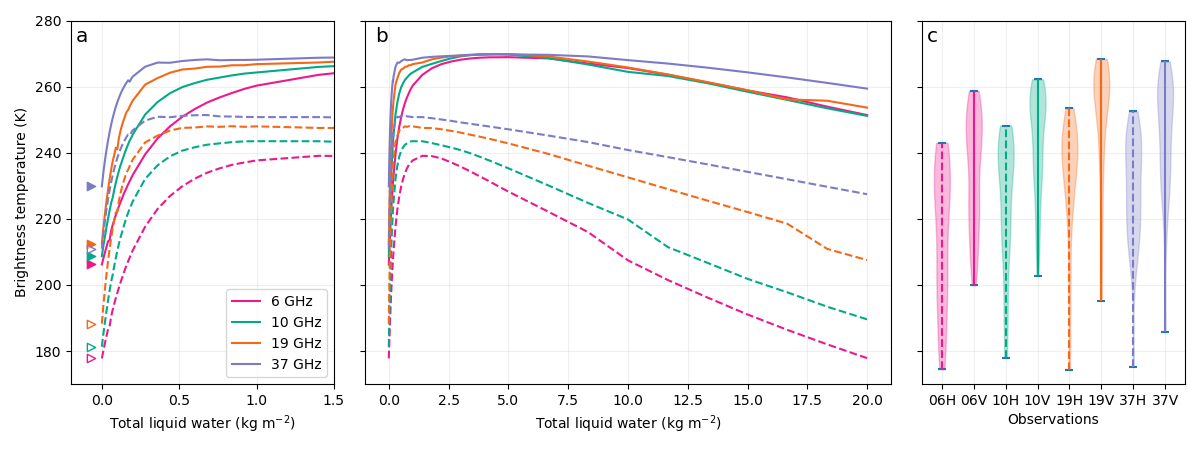

In [6]:
withobs = wet_mixing == 'MEMLS'

if withobs:
    ngraphs = 3
    figsize = (12, 4.5)
    width_ratios = [1, 2, 1]
else:
    ngraphs = 2
    figsize = (8, 4.5)
    width_ratios = [1, 2]

f, axs = plt.subplots(1, ngraphs, sharey=True,
                      figsize=figsize, gridspec_kw=dict(width_ratios=width_ratios)) #, sharex=True)
#axs = [axs]

for i in range(2):
    for ch in freqs:

        axs[i].plot(twc, presult[ch + 'V'], color=frequency_colors[ch], label=f'{int(ch)} GHz')
        axs[i].plot(twc, presult[ch + 'H'], '--', color=frequency_colors[ch])
        
        if i == 0:
            axs[i].scatter(-0.07, presult[ch + 'V'].iloc[0], marker='>', color=frequency_colors[ch])
            axs[i].scatter(-0.07, presult[ch + 'H'].iloc[0], marker='>', color='#ffffff80', edgecolor=frequency_colors[ch])

        axs[i].grid(alpha=0.2)
        
for i in [0, 1]:
    axs[i].set_xlabel("Total liquid water (kg m$^{-2}$)")

axs[0].set_ylabel("Brightness temperature (K)")
#axs[1].axes.yaxis.set_ticklabels([])
axs[0].legend()


axs[0].set_xlim((-0.2, 1.5))
axs[0].set_ylim((170, 280))

if withobs:
    # violin plots
    tb = pd.read_csv(f"DreamData/tb-melt-distribution-aws19.csv").set_index('time')
    tb = tb.drop(columns=['01H', '01V'])
    parts = axs[2].violinplot(tb.interpolate());

    colors = []
    for body, ch in zip(parts['bodies'], tb.columns):
        color = frequency_colors[ch[0:2]]
        body.set_facecolor(color)
        body.set_edgecolor(color)
        colors.append(color)
    parts['cbars'].set_edgecolor(colors)
    parts['cbars'].set_linestyle(['-' if ch[2] == 'V' else '--' for ch in tb.columns])

    axs[2].set_xticklabels(tb.columns)
    axs[2].set_xticks(range(1, len(tb.columns) + 1))
    axs[2].set_xlabel("Observations")
    axs[2].grid(alpha=0.2)
    
titles = 'abc'
for i in [0, 1, 2]:
    if i >= ngraphs:
        break
    axs[i].annotate(titles[i], xy=(0.02, 0.94), xycoords='axes fraction', fontsize='x-large')

plt.tight_layout()
plt.savefig(f"fig-{location}-{season}-{wet_mixing}-experiment1.pdf")

## Determine TWC threshold for M + 30K  and M + 20 K melt detection algorithms

In [7]:
print("M+30K")
for ch in presult.columns:
    print(ch, ((presult[ch] - presult[ch][0.0]) > 30).idxmax())

print("-------------")
print("M+20K")
for ch in presult.columns:
    print(ch, ((presult[ch] - presult[ch][0.0]) > 20).idxmax())

M+30K
06H 0.18
06V 0.28
10H 0.11
10V 0.14
19H 0.08
19V 0.11
37H 0.12
37V 0.15
-------------
M+20K
06H 0.11
06V 0.14
10H 0.07
10V 0.08
19H 0.05
19V 0.06
37H 0.06
37V 0.07


# Experiment 1: Heterogeneous wetness

In [8]:


def resample_brightness_temperature(twc, sigma_twc):
    
    def sample(twc0):
        twc_heterogeneous = np.random.normal(twc0, sigma_twc, 10000)
        twc_heterogeneous[twc_heterogeneous < 0] = 0
        return twc_heterogeneous
        
    def diff_mean_sample(twc0):
        return np.mean(sample(twc0)) - twc

    if sigma_twc > 0:
        twc0 = scipy.optimize.brentq(diff_mean_sample, twc - 5 * sigma_twc, twc + 1 * sigma_twc)
        twc_heterogeneous = sample(twc0)
    else:
        twc_heterogeneous = [twc]
    
    tb = {}
    for var in presult.columns:
        tb_heterogeneous = np.interp(twc_heterogeneous, presult.index, presult[var])
        tb[var] = np.mean(tb_heterogeneous)
        
    tb['twc'] = np.mean(twc_heterogeneous)
    return tb

sigma_twc = [0, 0.5, 1, 2]

presult_heterogeneous = {}
for s in sigma_twc:
    presult_heterogeneous[s] = pd.DataFrame([resample_brightness_temperature(twc0, s) for twc0 in twc]).set_index('twc')


    



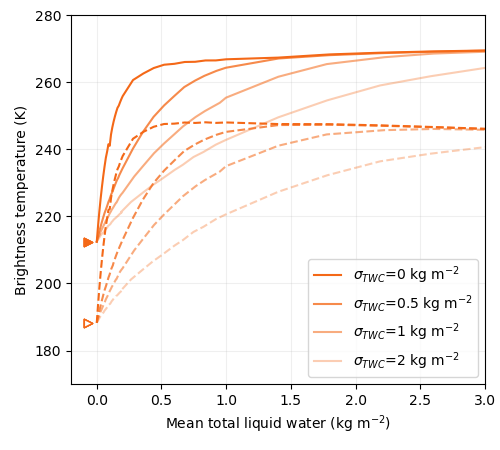

In [9]:
f, axs = plt.subplots(1, 1, sharey=True,
                      figsize=(5, 4.5))
axs = [axs]

for i, s in enumerate(sigma_twc):
    for ch in ['19']:
        
        alpha = alpha=1 - i * 0.9 / len(sigma_twc)


        axs[0].plot(presult_heterogeneous[s].index,
                    presult_heterogeneous[s][ch + 'V'], color=frequency_colors[ch], alpha=alpha, label=f'$\sigma_{{TWC}}$={s} kg m$^{{-2}}$')
        axs[0].plot(presult_heterogeneous[s].index,
                    presult_heterogeneous[s][ch + 'H'], '--', alpha=alpha, color=frequency_colors[ch])
        
        axs[0].scatter(-0.07, presult[ch + 'V'].iloc[0], marker='>', color=frequency_colors[ch])
        axs[0].scatter(-0.07, presult[ch + 'H'].iloc[0], marker='>', color='#ffffff80', edgecolor=frequency_colors[ch])

        axs[0].grid(alpha=0.2)
        
for i in [0]:
    axs[i].set_xlabel("Mean total liquid water (kg m$^{-2}$)")

axs[0].set_ylabel("Brightness temperature (K)")
#axs[1].axes.yaxis.set_ticklabels([])
axs[0].legend()
plt.tight_layout()

axs[0].set_xlim((-0.2, 3))
axs[0].set_ylim((170, 280))

plt.savefig(f"fig-{location}-{season}-heterogeneous-experiment1.pdf")

# Experiment 1 - Multi-site sensitivity with a 10cm surface wet snow layer

In [10]:


filename = "LWCSensitivityData-Original/results-allsites-experiment1.csv"

if not os.path.exists(filename):
    presult_sites = []
    for site in sites:

        drysp = GoodSnowpacks(site, "winter").prepare_best_snowpack()
        snowpacks = [prepare_wet_snowpacks(drysp, 0.0, 0.10, total_liquid_water=twc_) for twc_ in twc]

        res = run_simulations(snowpacks, snowpack_dimension=('twc', twc))

        res['site'] = site
        presult_sites.append(res)

    presult_sites = pd.concat(presult_sites).reset_index().set_index(['site', 'twc'])
    presult_sites.to_csv(filename)
else:
    presult_sites = pd.read_csv(filename)    
    presult_sites = presult_sites.reset_index().set_index(['site', 'twc'])


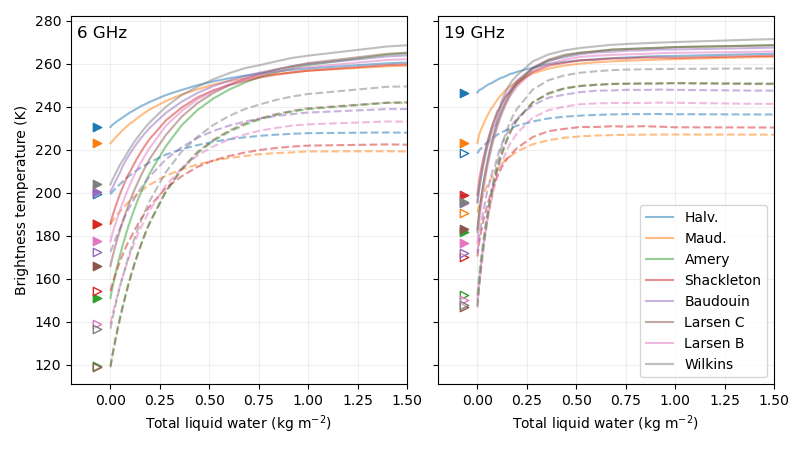

In [11]:
f, axs = plt.subplots(1, 2, sharey=True,
                      figsize=(8, 4.5))


for i, ch in enumerate(['06', '19']):

    label = f'{int(ch)} GHz'
    #axs[i].set_title(label)
    axs[i].annotate(label, xy=(0.017, 0.94), fontsize='large', xycoords=('axes fraction', 'axes fraction'))
    for site in sites:
        pres = presult_sites.loc[site]

        l, = axs[i].plot(twc, pres[ch + 'V'], label=site_name(site), alpha=0.5)
        color = l.get_color()
        axs[i].plot(twc, pres[ch + 'H'], '--', color=color, alpha=0.5)

        axs[i].scatter(-0.07, pres[ch + 'V'].iloc[0], marker='>', color=color)
        axs[i].scatter(-0.07, pres[ch + 'H'].iloc[0], marker='>', color='#ffffff80', edgecolor=color)

    
        
for i in [0, 1]:
    axs[i].set_xlabel("Total liquid water (kg m$^{-2}$)")
    axs[i].grid(alpha=0.2)
    axs[i].set_xlim((-0.2, 1.5))


axs[0].set_ylabel("Brightness temperature (K)")
#axs[1].axes.yaxis.set_ticklabels([])
axs[1].legend()
plt.tight_layout()


plt.savefig(f"fig-allsites-winter-experiment1.pdf")

# Experiment 2 - Sensitivity to the wet snow layer thickness. 

In [12]:
twc = np.arange(0, 0.5, 0.02)

lwc = np.arange(0, 0.5, 0.02) * 0.01

thickness_list = [0.01, 0.02, 0.05, 0.10, 0.50]

presult_thickness = []
presult_thickness_lwc = []

filename1 = "LWCSensitivityData-Original//results-aws19-twc-experiment2.csv"
filename2 = "LWCSensitivityData-Original//results-aws19-lwc-experiment2.csv"

if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):

    for thickness in thickness_list:

        snowpacks = pd.DataFrame({"snowpack": [prepare_wet_snowpacks(drysp, 0.0, thickness, total_liquid_water=twc_) for twc_ in twc]})
        snowpacks['thickness'] = thickness
        snowpacks['twc'] = twc
        
        res = run_simulations(snowpacks)

        presult_thickness.append(res)


        snowpacks = pd.DataFrame({"snowpack": [prepare_wet_snowpacks(drysp, 0.0, thickness, total_liquid_water=lwc_ * thickness * 1000) for lwc_ in lwc]})
        snowpacks['thickness'] = thickness
        snowpacks['lwc'] = lwc
        
        res = run_simulations(snowpacks)

        presult_thickness_lwc.append(res)


    presult_thickness = pd.concat(presult_thickness).reset_index().set_index(['thickness', 'twc'])
    presult_thickness_lwc = pd.concat(presult_thickness_lwc).reset_index().set_index(['thickness', 'lwc'])
    
    presult_thickness.to_csv(filename1)
    presult_thickness_lwc.to_csv(filename2)
else:
    presult_thickness = pd.read_csv(filename1)
    presult_thickness_lwc = pd.read_csv(filename2)
    
    presult_thickness = presult_thickness.set_index(['thickness', 'twc'])
    presult_thickness_lwc = presult_thickness_lwc.set_index(['thickness', 'lwc'])

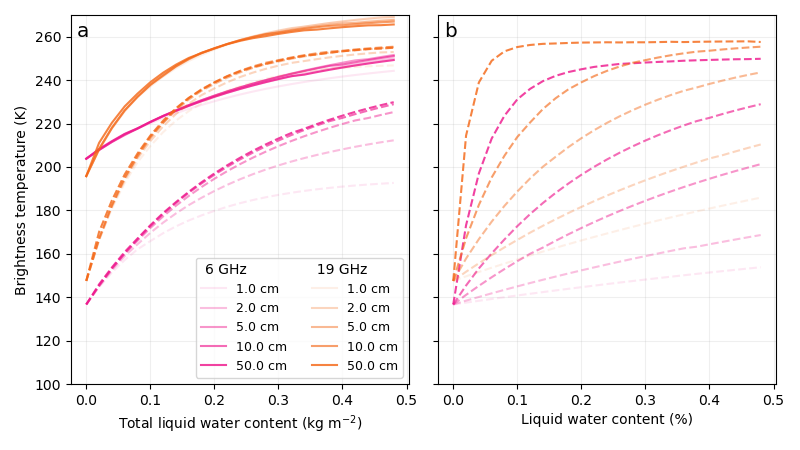

In [13]:
f, axs = plt.subplots(1, 2, figsize=(8, 4.5), sharey=True)


for ch in ['06', '19']:
    for i, thickness in enumerate(thickness_list):
        pres = presult_thickness.loc[thickness]
        pres_lwc = presult_thickness_lwc.loc[thickness]
    
        alpha = alpha=0.1 + i * 0.9 / len(thickness_list)

        label = f"{thickness * 100} cm"
        axs[0].plot(twc, pres[ch + 'V'], color=frequency_colors[ch], alpha=alpha, label=label)
        axs[0].plot(twc, pres[ch + 'H'], '--', color=frequency_colors[ch], alpha=alpha)
    
        axs[1].plot(lwc * 100, pres_lwc[ch + 'H'], '--', color=frequency_colors[ch], alpha=alpha)


titles = 'ab'

for i in [0, 1]:
    #axs[i].legend()
    axs[i].grid(alpha=0.2)
    axs[i].annotate(titles[i], xy=(0.017, 0.94), fontsize='x-large', xycoords=('axes fraction', 'axes fraction'))

axs[0].set_ylim((100, 270))
axs[0].legend(ncol=2, fontsize=9, title='6 GHz                19 GHz      ')  # a bith hacky


axs[0].set_xlabel("Total liquid water content (kg m$^{-2}$)")
axs[1].set_xlabel("Liquid water content (%)")
axs[0].set_ylabel("Brightness temperature (K)")
#axs[1].set_ylabel("Backscattering coefficient")
plt.tight_layout()

plt.savefig('fig-aws19-experiment2.pdf')

# Experiment 3 - Depth sensitivity (Ensemble run). 

In [14]:
presult_depth = {}
presult0 = {}
snowpacks = {}

for loc in [location, "aws11"]:

    n = 100
    
    if loc == location:
        drysps = site0.prepare_good_snowpacks(size=n, season_temperature=273, as_dataframe=True)
    else:
        drysps = GoodSnowpacks(loc, "winter", version=31).prepare_good_snowpacks(size=n, season_temperature=273, as_dataframe=True)

    drysps['drysp'] = drysps.index

    fixed_twc = 1.5  # kg/m2

    filename = f"LWCSensitivityData-Original/results-{loc}-set{n}-experiment3.csv"
    filename0 = f"LWCSensitivityData-Original//results-{loc}-0-set{n}-experiment3.csv"

    depths = list(np.linspace(0, 2, 20, endpoint=False)) + list(np.linspace(2, 8, 16))  + [10, 15]

    snowpacks[loc] = drysps.join(pd.DataFrame({"depth": depths}), how='cross')
    snowpacks[loc] = snowpacks[loc].rename(columns={'snowpack': 'dry_snowpack'})
    snowpacks[loc]['snowpack'] = [prepare_wet_snowpacks(row.dry_snowpack,
                                             0.0 + row.depth,
                                             0.10 + row.depth,
                                             total_liquid_water=fixed_twc) for i, row in snowpacks[loc].iterrows()]

    if not os.path.exists(filename):

        print('run', len(snowpacks[loc]))

        presult_depth[loc] = run_simulations(snowpacks[loc])

        presult0[loc] = run_simulations(drysps)

        # remove some columns before saving
        del presult_depth[loc]['dry_snowpack']
        presult_depth[loc].to_csv(filename)
        presult0[loc].to_csv(filename0)
    else:
        presult_depth[loc] = pd.read_csv(filename)
        presult0[loc] = pd.read_csv(filename0)

    presult_depth[loc] = presult_depth[loc].set_index(['depth', 'drysp'])
    snowpacks[loc] = snowpacks[loc].set_index(['depth', 'drysp'])


In [15]:
def weighted_mean(x):    
    return pd.Series({c: np.average(x[c], weights=x.weight / np.sum(x.weight), axis=0) for c in x.columns})
        

for loc in presult_depth:
    presult_depth[loc] = presult_depth[loc].groupby("depth").apply(weighted_mean)
    presult0[loc] = weighted_mean(presult0[loc])

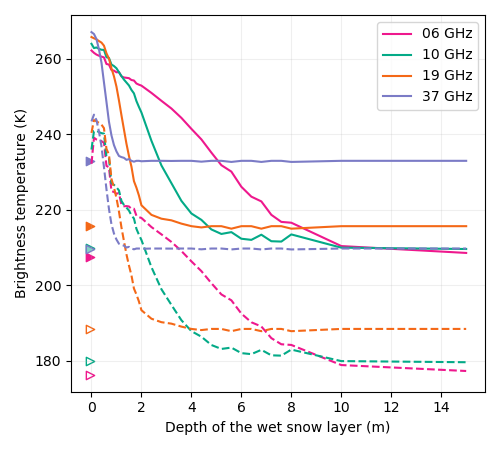

In [16]:
f, axs = plt.subplots(1, 1, figsize=(5, 4.5))
axs = [axs]

for ch in ['06', '10', '19', '37']: 
#for ch in frequency_colors:
    
    axs[0].plot(depths, presult_depth[location][ch + 'V'], '-', color=frequency_colors[ch], label=f'{ch} GHz')
    axs[0].plot(depths, presult_depth[location][ch + 'H'], '--', color=frequency_colors[ch]) 

    axs[0].scatter(-0.07, presult0[location][ch + 'V'], marker='>', color=frequency_colors[ch])
    axs[0].scatter(-0.07, presult0[location][ch + 'H'], marker='>', color='#ffffff80', edgecolor=frequency_colors[ch])

axs[0].grid(alpha=0.2)
for i in [0]:
    axs[i].legend()
    axs[i].set_xlabel("Depth of the wet snow layer (m)")
axs[0].set_ylabel("Brightness temperature (K)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('fig-aws19-experiment3.pdf')


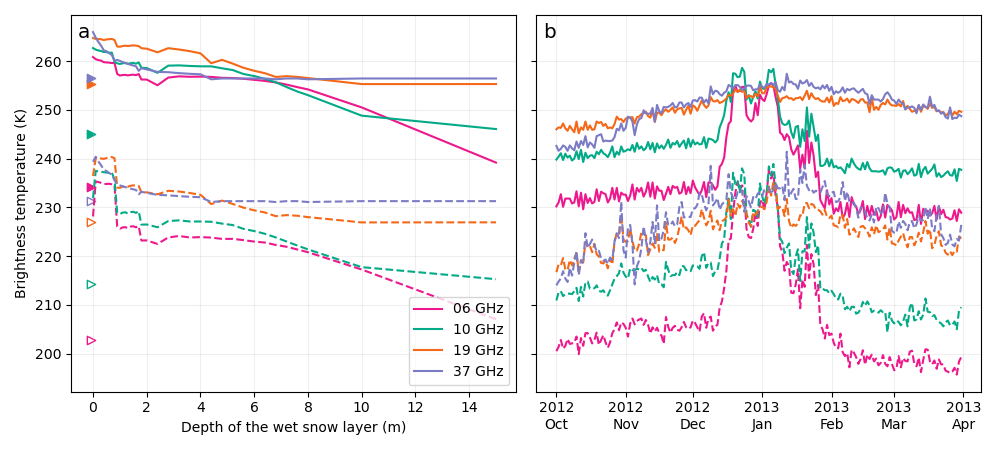

In [17]:
f, axs = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

loc = 'aws11'
obs = pd.read_csv(f"AMSR2Data/timeseries-{loc}.csv", parse_dates=['time']).set_index('time')


for ch in ['06', '10', '19', '37']: 
    
    axs[0].plot(depths, presult_depth[loc][ch + 'V'], '-', color=frequency_colors[ch], label=f'{ch} GHz')
    axs[0].plot(depths, presult_depth[loc][ch + 'H'], '--', color=frequency_colors[ch])

    axs[0].scatter(-0.07, presult0[loc][ch + 'V'], marker='>', color=frequency_colors[ch])
    axs[0].scatter(-0.07, presult0[loc][ch + 'H'], marker='>', color='#ffffff80', edgecolor=frequency_colors[ch])

    axs[1].plot(obs.index, obs[ch + 'V'], '-', color=frequency_colors[ch])
    axs[1].plot(obs.index, obs[ch + 'H'], '--', color=frequency_colors[ch])
    
    

axs[0].legend(loc='lower right')
axs[0].set_xlabel("Depth of the wet snow layer (m)")
axs[0].set_ylabel("Brightness temperature (K)")

axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y\n%b"))

titles = 'ab'
for i in [0, 1]:
    axs[i].grid(alpha=0.2)
    axs[i].annotate(titles[i], xy=(0.015, 0.94), fontsize='x-large', xycoords=('axes fraction', 'axes fraction'))

    
plt.tight_layout()
plt.savefig('fig-aws11-experiment3.pdf')

In [18]:
# print detection depth for each frequency
detection_depth = (presult_depth[location] - presult_depth[location].iloc[-1]  < 20).idxmax()
detection_depth

Unnamed: 0    0.0
06H           5.6
06V           6.0
10H           2.8
10V           3.2
19H           1.4
19V           1.5
37H           0.6
37V           0.6
weight        0.0
dtype: float64

In [19]:

filename = "LWCSensitivityData-Original/results-allsites-experiment3.csv"

fixed_twc = 1.5  # kg/m2
snowpacks = []

for season in ['winter', 'autumn']:
    for site in sites:
  
        drysps = GoodSnowpacks(site, season, version=31).prepare_good_snowpacks(size=100, season_temperature=273, as_dataframe=True)
        drysps['drysp'] = drysps.index

        depths = list(np.linspace(0, 2, 20, endpoint=False)) + list(np.linspace(2, 8, 16))  + [10, 15]

        sps = drysps.join(pd.DataFrame({"depth": depths}), how='cross')
        sps = sps.rename(columns={'snowpack': 'dry_snowpack'})
        sps['snowpack'] = [prepare_wet_snowpacks(row.dry_snowpack,
                                                 0.0 + row.depth,
                                                 0.10 + row.depth,
                                                 total_liquid_water=fixed_twc) for i, row in sps.iterrows()]
        sps['site'] = site
        sps['season'] = season
        snowpacks.append(sps)

snowpacks = pd.concat(snowpacks)

print("#snowpacks=", len(snowpacks))
if not os.path.exists(filename):
    
    print('run')
    presult_all_depth = run_simulations(snowpacks)
    
    # remove some columns before saving
    del presult_all_depth['dry_snowpack']
    presult_all_depth.to_csv(filename)
else:
    presult_all_depth = pd.read_csv(filename)


#snowpacks= 2508


In [20]:
presult_all_depth = presult_all_depth.groupby(['site', 'season', 'depth']).apply(weighted_mean)

In [21]:
def detection_depth(x):
    site = x.index.get_level_values(0)[0]
    
    ref = presult_all_depth.loc[site, :, 15.0]
    idx = (x - ref  < 20).idxmax()
    return idx.map(lambda x: x[2]) 

detection_depths = presult_all_depth.groupby(['site', 'season']).apply(detection_depth)[channels]
detection_depths



06H  06V  10H  10V  19H  19V  37H  37V
site       season                                        
amery      autumn  6.4  6.8  4.0  4.4  1.7  1.8  0.5  0.5
           winter  6.0  6.4  4.0  4.4  2.0  2.4  0.8  0.8
aws11      autumn  0.0  6.8  0.0  0.0  0.0  0.0  0.0  0.0
           winter  0.9  0.9  0.0  0.0  0.0  0.0  0.0  0.0
aws15      autumn  4.8  5.6  3.2  3.6  1.5  1.6  0.5  0.6
           winter  5.2  6.0  3.6  3.6  1.8  1.8  0.8  0.9
aws17      autumn  6.0  6.4  3.2  3.6  1.6  1.7  0.6  0.7
           winter  4.4  4.8  2.4  2.8  1.2  1.3  0.5  0.5
aws19      autumn  5.2  5.6  3.2  3.6  1.6  1.7  0.7  0.7
           winter  5.6  6.0  2.8  3.2  1.4  1.5  0.6  0.6
aws5       autumn  1.8  2.8  1.2  1.8  1.2  1.1  0.0  0.0
           winter  4.4  5.6  2.4  2.4  0.0  1.3  0.0  0.0
shackleton autumn  4.8  5.2  2.8  3.2  1.4  1.5  0.6  0.6
           winter  5.6  6.0  3.2  3.2  1.5  1.6  0.0  0.5
wilkins    autumn  1.5  1.9  2.4  2.8  1.4  1.6  0.6  0.7
           winter  3.2  4.8  2.4  3.2  1.6  1.8  0.9  0.9

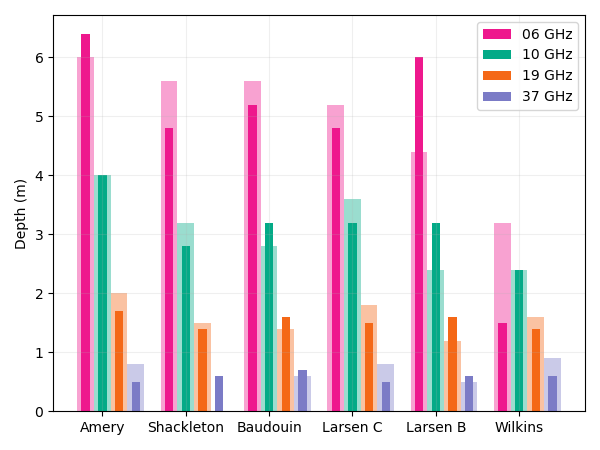

In [22]:
f, axs = plt.subplots(1, 1, figsize=(6, 4.5))
axs = [axs]

subsites = [s for s in sites if s != "aws11" and s!= "aws5"]

ind = np.arange(1, len(subsites) + 1) - 0.4
width = 0.2


for i, ch in enumerate(['06H', '10H', '19H', '37H']):
    axs[0].bar(ind + i * width, detection_depths.loc[(subsites, 'winter'), ch], width=width, 
            color=frequency_colors[ch[0:2]], alpha=0.4)
    axs[0].bar(ind + i * width, detection_depths.loc[(subsites, 'autumn'), ch], width=width*0.5, 
            color=frequency_colors[ch[0:2]], alpha=1, label=f'{ch[0:2]} GHz')

    ratio = detection_depths.loc[(subsites, 'autumn') , ch].droplevel(1) / detection_depths.loc[(subsites, 'winter'), ch].droplevel(1) 
    
axs[0].set_xticks(ind+width)
axs[0].set_xticklabels(site_name(subsites));
axs[0].set_ylabel("Depth (m)")

axs[0].legend(loc='upper right')
for i in [0, 1]:
    axs[0].grid(alpha=0.2)
    

plt.tight_layout()

plt.savefig("fig-allsites-experiment3.pdf")

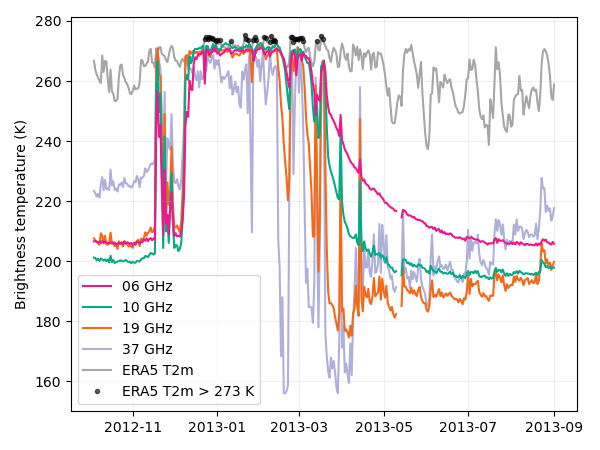

In [23]:
f, axs = plt.subplots(1, 1, figsize=(6, 4.5))
axs = [axs]

obs = pd.read_csv(f"AMSR2Data/timeseries-wilkins.csv", parse_dates=['time']).set_index('time')


for i, ch in enumerate(['06', '10', '19', '37']): 
    
    alpha = 0.6 if ch == '37' else 1
    axs[0].plot(obs.index, obs[ch + 'V'], '-', alpha=alpha, color=frequency_colors[ch], label=f'{ch[0:2]} GHz', zorder=-i)

axs[0].plot(obs.index, obs['t2m'], '-', alpha=0.35, color='k', label=f'ERA5 T2m', zorder=-10)
melting = obs['t2m'] >= 273
axs[0].plot(obs.index[melting], obs['t2m'][melting], '.', alpha=0.6, color='k', label=f'ERA5 T2m > 273 K')

plt.grid(alpha=0.2)

axs[0].legend(loc='lower left')
axs[0].set_ylabel("Brightness temperature (K)")

plt.tight_layout()
plt.savefig('fig-timeseries-wilkins.pdf')

In [24]:
def diff_season(x):
    return x.loc[(slice(None), 'autumn')] - x.loc[(slice(None), 'winter')]
    
detection_depths.groupby("site").agg(diff_season)

,06H,06V,10H,10V,19H,19V,37H,37V
site,,,,,,,,
amery,0.4,0.4,0.0,0.0,-0.3,-0.6,-0.3,-0.3
aws11,-0.9,5.9,0.0,0.0,0.0,0.0,0.0,0.0
aws15,-0.4,-0.4,-0.4,0.0,-0.3,-0.2,-0.3,-0.3
aws17,1.6,1.6,0.8,0.8,0.4,0.4,0.1,0.2
aws19,-0.4,-0.4,0.4,0.4,0.2,0.2,0.1,0.1
aws5,-2.6,-2.8,-1.2,-0.6,1.2,-0.2,0.0,0.0
shackleton,-0.8,-0.8,-0.4,0.0,-0.1,-0.1,0.6,0.1
wilkins,-1.7,-2.9,0.0,-0.4,-0.2,-0.2,-0.3,-0.2


# Experiment 4 - Presence of Lakes

In [25]:
lake = make_ice_column("firstyear", thickness=[0.01], density=0.01, temperature=273,
                       microstructure_model="homogeneous", add_water_substrate=True)


site = GoodSnowpacks("aws19", "winter")
drysp = site0.prepare_best_snowpack()

m_iba = make_model("iba", "odort", rtsolver_options=dict(n_max_stream=92, prune_deep_snowpack=5, error_handling='nan'))

twc = 1.5
snowpack = prepare_wet_snowpacks(drysp, 0.0, 0.10, total_liquid_water=twc)

radiometer = sensor_list.amsre(channels)

presult_drysnow = m.run(radiometer, drysp).to_dataframe()
presult_snow = m.run(radiometer, snowpack).to_dataframe()

presult_lake = m_iba.run(radiometer, lake).to_dataframe()


/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)
/home/picardgh/miniconda3/envs/smrt/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:635: ComplexWarning: Casting complex values to real discards the imaginary part
  h = Ninterv * np.asarray(dx, dtype=float)


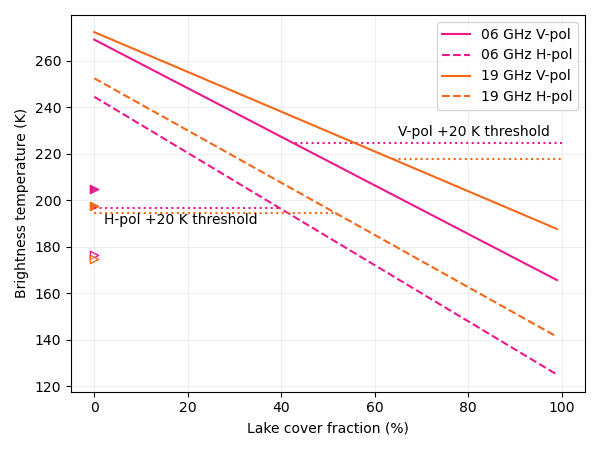

In [26]:
lake_cover = np.arange(0, 1, 0.01)
presult = pd.concat([presult_lake *alpha + presult_snow * (1 - alpha) for alpha in lake_cover]).set_index(lake_cover)
    
f, axs = plt.subplots(1, 1, figsize=(6, 4.5), sharey=True)
axs = [axs]

for ch in ['06', '19']: #frequency_colors:
#for ch in frequency_colors:
    axs[0].plot(lake_cover * 100, presult[ch + 'V'], '-', color=frequency_colors[ch], label=f'{ch} GHz V-pol')
    axs[0].plot(lake_cover * 100, presult[ch + 'H'], '--', color=frequency_colors[ch], label=f'{ch} GHz H-pol')
        
    tbdry = presult_drysnow + 20
    
    
    #axs[0].plot(lake_cover[mask], presult[ch + 'V'][mask], '-', lw=3, color=frequency_colors[ch], label=f'{ch} GHz V-pol')
    #axs[0].plot(lake_cover, presult[ch + 'H'], '--', color=frequency_colors[ch], label=f'{ch} GHz H-pol')
    
    for pol in 'VH':
        mask = presult[ch + pol] < float(tbdry[ch + pol])
        lc_th = lake_cover[np.argmax(mask)]        
        x = [lc_th * 100, 100] if pol == 'V' else [0, lc_th * 100]
        axs[0].plot(x, [tbdry[ch + pol], tbdry[ch + pol]], ':', color=frequency_colors[ch])
    
    if ch == '06':
        axs[0].annotate("V-pol +20 K threshold", xy=(65, tbdry[ch + 'V'] + 3))
        axs[0].annotate("H-pol +20 K threshold", xy=(2, tbdry[ch + 'H'] - 7))
    
    axs[0].scatter([0], [presult_drysnow[ch + 'V']], marker='>', color=frequency_colors[ch])
    axs[0].scatter([0], [presult_drysnow[ch + 'H']], marker='>', color='#ffffff80', edgecolor=frequency_colors[ch])
        #if ch == '06':
        #    axs[i].annotate("Winter T$_B$", xy=[0, tbdry + 2])

for i in [0]:
    axs[i].grid(alpha=0.2)
    axs[i].legend()
    axs[i].set_xlabel("Lake cover fraction (%)")
axs[0].set_ylabel("Brightness temperature (K)")
plt.tight_layout()
plt.savefig("fig-lakes-experiment4.pdf")

# Experiment 4 - Saturated layer

In [27]:
# saturated layer at the surface, as a function of the ice density


drysp = site0.prepare_best_snowpack(season_temperature=273)

zmax = 0.05

sp = []

densities = np.arange(10, 917, 10)

filename = "LWCSensitivityData-Original/results-saturation-experiment4.csv"
filename2 = os.path.splitext(filename)[0] + "-2.csv"

m_sce = make_model("symsce_torquato21", "odort", rtsolver_options=dict(n_max_stream=128, prune_deep_snowpack=5, error_handling='nan'))


if not os.path.exists(filename):
    
    saturatedsp = [prepare_saturated_snowpacks(drysp, 0.0, zmax, dry_density=dens) for dens in densities]

    presult_saturated = m_sce.run(radiometer, saturatedsp, snowpack_dimension=('dry_density', densities), 
                                parallel_computation=True, runner=runner).to_dataframe()
    presult_saturated.to_csv(filename)
    
    saturatedsp2 = [prepare_saturated_snowpacks(drysp, 0.05, zmax + 0.05, dry_density=dens) for dens in densities]
    for s in saturatedsp2:
        s.layers[0].__dict__['liquid_water'] = 0.05  # add water !

    presult_saturated2 = m_sce.run(radiometer, saturatedsp2, snowpack_dimension=('dry_density', densities), 
                                parallel_computation=True, runner=runner).to_dataframe()
    presult_saturated2.to_csv(filename2)

else:
    presult_saturated = pd.read_csv(filename).set_index('dry_density')
    presult_saturated2 = pd.read_csv(filename2).set_index('dry_density')


06H    0.989095
06V    0.989095
10H    0.989095
10V    0.989095
19H    0.989095
19V    0.989095
37H    0.989095
37V    0.989095
dtype: float64

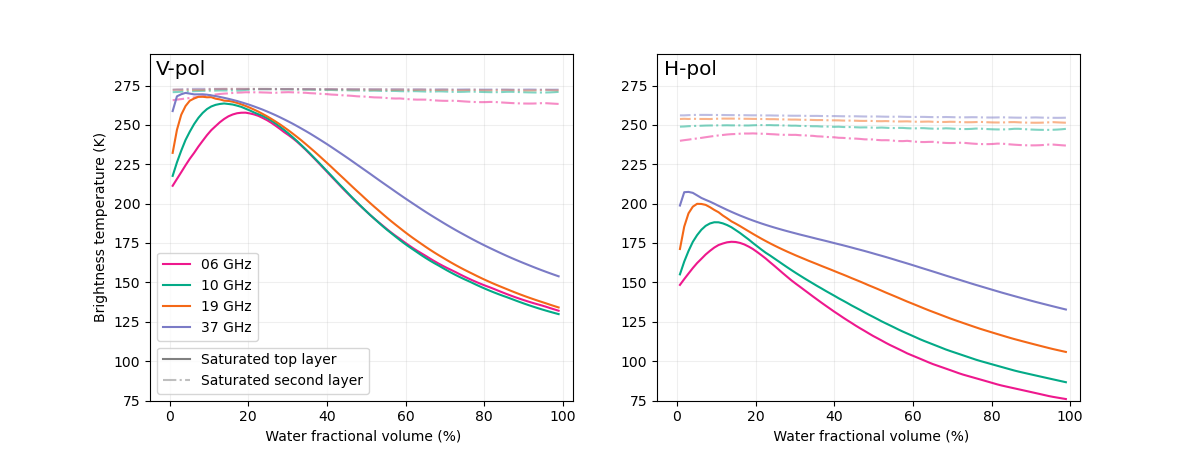

In [28]:
f, axs = plt.subplots(1, 2, figsize=(12, 4.5))

for ch in ['06', '10', '19', '37']: #frequency_colors:
    for i, pola in enumerate('VH'):
        frac = 1 - presult_saturated.index / 917
        axs[i].plot(frac * 100, presult_saturated[ch + pola], color=frequency_colors[ch], label=f'{ch} GHz')
        axs[i].plot(frac * 100, presult_saturated2[ch + pola], '-.', alpha=0.5, color=frequency_colors[ch]) 

titles = ['V-pol', 'H-pol']
for i in [0, 1]:
    axs[i].grid(alpha=0.2)
    axs[i].set_xlabel(" Water fractional volume (%)")
    axs[i].annotate(titles[i], xy=(0.015, 0.94), fontsize='x-large', xycoords=('axes fraction', 'axes fraction'))
    axs[i].set_xlim((-5, 102.5))
    
axs[0].set_ylim((75, 295))
axs[1].set_ylim((75, 295))

axs[0].set_ylabel("Brightness temperature (K)")

l = axs[0].legend(loc='center left', bbox_to_anchor=(0, 0.3))

axs[0].add_artist(l)

gray_lines = [mlines.Line2D([], [], color='gray', label='Saturated top layer'),
              mlines.Line2D([], [], linestyle='-.', alpha=0.5, color='gray', label='Saturated second layer')]

axs[0].legend(loc='lower left', handles=gray_lines, labels=[l.get_label() for l in gray_lines])
plt.savefig("fig-aws19-saturated-experiment4.pdf")

detection_fraction = 1 - (presult_saturated - presult.iloc[0] < 20).idxmin() / 917
detection_fraction